# Training a Hierarchical DivNoising network for Convallaria data which is intrinsically noisy
This notebook contains an example on how to train a Hierarchical DivNoising Ladder VAE for an intrinsically noisy data. This requires having a noise model (model of the imaging noise) which can be either measured from calibration data or bootstrapped from raw noisy images themselves. If you haven't done so, please first run '1-CreateNoiseModel.ipynb', which will download the data and create a noise model. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
use_cuda
device

device(type='cuda')

### Specify ```path``` to load training data
Your data should be stored in the directory indicated by ```path```.

In [4]:
path="/group/jug/Sheida/maester_data/download/high_c1/"
observation= imread(path+'high_c1_source.tif')

# Training Data Preparation

For training we need to follow some preprocessing steps first which will prepare the data for training purposes.

We first divide the data into training and validation sets with 85% images allocated to training set  and rest to validation set. Then we augment the training data 8-fold by 90 degree rotations and flips.

In [5]:
train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
# train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (932, 699, 760) Shape of validation images: (165, 699, 760)


In [6]:
### We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images.
### Usually 64x64 patches work well for most microscopy datasets
patch_size = 128

In [7]:
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)
train_images = utils.extract_patches(train_data, patch_size, num_patches)
train_images = train_images[:5000]
val_images = utils.extract_patches(val_data, patch_size, num_patches)
val_images = val_images[:500] # We limit validation patches to 1000 to speed up training but it is not necessary
test_images = val_images[:100]
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 165/165 [00:00<00:00, 1142.71it/s]

Shape of training images: (5000, 128, 128) Shape of validation images: (500, 128, 128)


# Configure Hierarchical DivNoising model

<code>model_name</code> specifies the name of the model with which the weights will be saved and wil be loaded later for prediction.<br>
<code>directory_path</code> specifies the directory where the model weights and the intermediate denoising and generation results will be saved. <br>
<code>gaussian_noise_std</code> is only applicable if dataset is synthetically corrupted with Gaussian noise of known std. For real datasets, it should be set to ```None```.<br>
<code>noiseModel</code> specifies a noise model for training. If noisy data is generated synthetically using Gaussian noise, set it to None. Else set it to the GMM based noise model (.npz file)  generated from '1-CreateNoiseModel.ipynb'.<br>
<code>batch_size</code> specifies the batch size used for training. The default batch size of $64$ works well for most microscopy datasets.<br>
<code>virtual_batch</code> specifies the virtual batch size used for training. It divides the <code>batch_size</code> into smaller mini-batches of size <code>virtual_batch</code>. Decrease this if batches do not fit in memory.<br>
<code>test_batch_size</code> specifies the batch size used for testing every $1000$ training steps. Decrease this if test batches do not fit in memory, it does not have any consequence on training. It is just for intermediate visual debugging.<br>
<code>lr</code> specifies the learning rate.<br>
<code>max_epochs</code> specifies the total number of training epochs. Around $150-200$ epochs work well generally.<br>
<code>steps_per_epoch</code> specifies how many steps to take per epoch of training. Around $400-500$ steps work well for most datasets.<br>
<code>num_latents</code> specifies the number of stochastic layers. The default setting of $6$ works well for most datasets but quite good results can also be obtained with as less as $4$ layers. However, more stochastic layers may improve performance for some datasets at the cost of increased training time.<br>
<code>z_dims</code> specifies the number of bottleneck dimensions (latent space dimensions) at each stochastic layer per pixel. The default setting of $32$ works well for most datasets.<br>
<code>blocks_per_layer</code> specifies how many residual blocks to use per stochastic layer. Usually, setting it to be $4$ or more works well. However, more residual blocks improve performance at the cost of increased training time.<br>
<code>batchnorm</code> specifies if batch normalization is used or not. Turning it to True is recommended.<br>
<code>free_bits</code> specifies the threshold below which KL loss is not optimized for. This prevents the [KL-collapse problem](https://arxiv.org/pdf/1511.06349.pdf%3Futm_campaign%3DRevue%2520newsletter%26utm_medium%3DNewsletter%26utm_source%3Drevue). The default setting of $1.0$ works well for most datasets.<br>

**__Note:__** With these settings, training will take approximately $24$ hours on Tesla P100/Titan Xp GPU needing about 6 GB GPU memory. We optimized the code to run on less GPU memory. For faster training, consider increasing ```virtual_batch_size``` but since we have not tested with different settings of ```virtual_batch_size```, we do not yet know how this affects results. To reduce traing time, also consider reducing either ```num_latents``` or ```blocks_per_layer``` to $4$. These settings will bring down the training time to around $12-15$ hours while still giving good results.

In [8]:
model_name = "HDN Muller"
directory_path = "./Trained_model/" 

# Data-specific
gaussian_noise_std = None
# noise_model_params= np.load("./data/Convallaria_diaphragm/GMMNoiseModel_convallaria_3_2_calibration.npz")
noiseModel = None #GaussianMixtureNoiseModel(params = noise_model_params, device = device)

# Training-specific
batch_size=32
virtual_batch = 16
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32, 64, 128, 256, 512] # [32]*int(num_latents)
blocks_per_layer = 5
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated

In [9]:
debug             = False #[True, False]
save_output       = True #[True, False]
project           = 'HDN_Muller'


# Train network

In [10]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0): TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), paddin

In [11]:


training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sheida-rk (juglab). Use `wandb login --relogin` to force relogin


Epoch[1/500] Training Loss: 1.234 Reconstruction Loss: 0.545 KL Loss: 0.688
saving ./Trained_model/model/HDN Muller_last_vae.net
saving ./Trained_model/model/HDN Muller_best_vae.net
Patience: 0 Validation Loss: 0.5065692067146301 Min validation loss: 0.5065692067146301
Time for epoch: 5seconds
Est remaining time: 0:41:35 or 2495 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.065 Reconstruction Loss: 0.511 KL Loss: 0.554
saving ./Trained_model/model/HDN Muller_last_vae.net
saving ./Trained_model/model/HDN Muller_best_vae.net
Patience: 0 Validation Loss: 0.4899441599845886 Min validation loss: 0.4899441599845886
Time for epoch: 4seconds
Est remaining time: 0:33:12 or 1992 seconds
----------------------------------------
Epoch[3/500] Training Loss: 1.072 Reconstruction Loss: 0.574 KL Loss: 0.499
saving ./Trained_model/model/HDN Muller_last_vae.net
saving ./Trained_model/model/HDN Muller_best_vae.net
Patience: 0 Validation Loss: 0.47933974862098694 Min valid

# Plotting losses

In [12]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

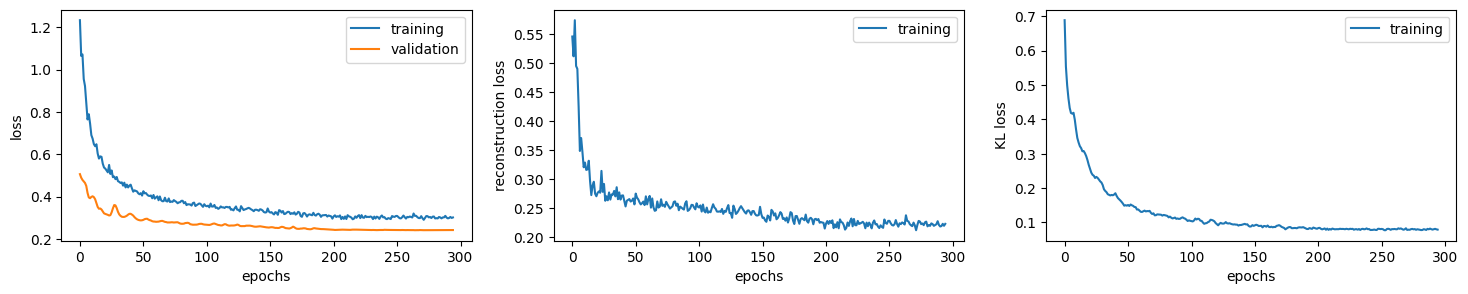

In [13]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()

In [14]:
directory_path = "./Trained_model/" 
model = torch.load(directory_path+"model/HDN Muller_best_vae.net")
model.mode_pred=True
model.eval()

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0): TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), paddin

In [15]:
observation[0].shape

(699, 760)

In [16]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images


## imge size
<br>
699, 760

### size of mu
[tensor[1, 32, 352, 384],
<br>
tensor[1, 32, 176, 192],
<br>
tensor[1, 32,  88,  96],
<br>
tensor[1, 32,  44,  48],
<br>
tensor[1, 32,  22,  24]]

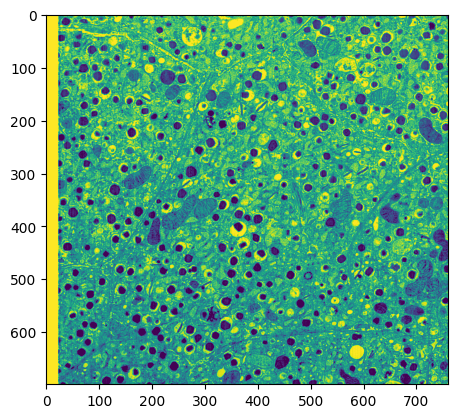

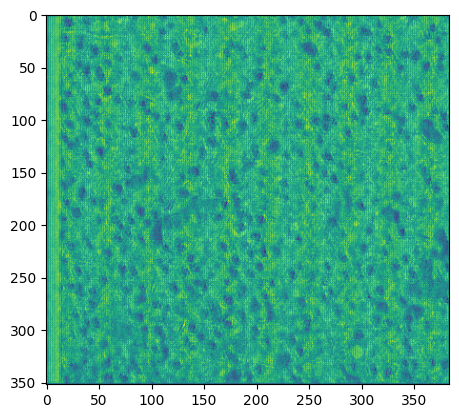

In [33]:
img = observation[0]
img_height,img_width = img.shape[0], img.shape[1]
img_t = get_normalized_tensor(img,model,device)
image_sample = img_t.view(1,1,img_height,img_width)
image_sample = image_sample.to(device=device, dtype=torch.float)
plt.imshow(observation[0])
plt.show()
with torch.no_grad():
    sample = model(image_sample)
    sample = sample['logvar'][0][0].cpu().numpy()
    # for i in range(32):
    #     _, ax = plt.subplots()
    #     plt.imshow(sample[i])
    #     ax.set_title(f'{i}')
    #     plt.show()
    #     plt.close()
    plt.imshow(sample[2])
    plt.show()
        


In [18]:
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans

In [45]:
def plotting(idx, mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(32*(2**idx), -1).T
    K_CENTRE = 20
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    print(22*(2**(4-idx)), 24*(2**(4-idx)))
    plt.imshow(labels_mu.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
    plt.axis('off')
    plt.show()


352 384


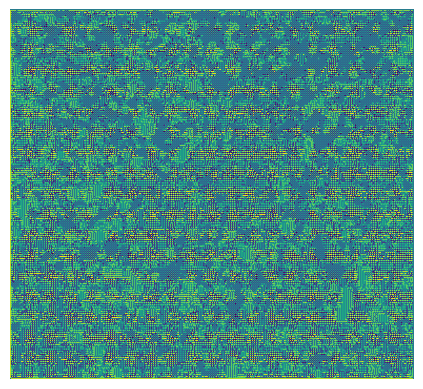

176 192


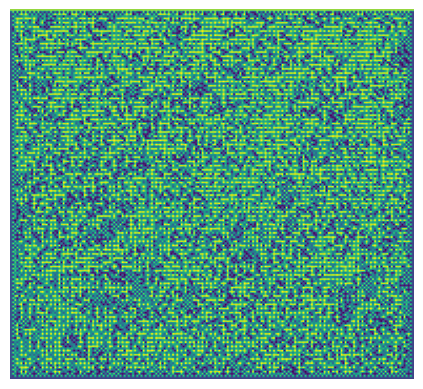

88 96


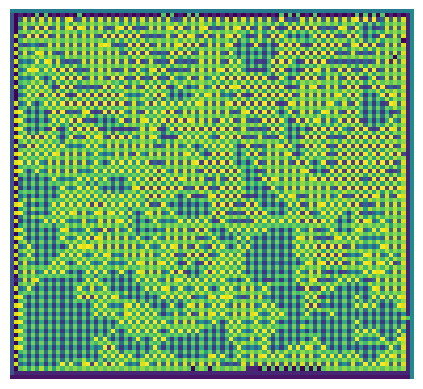

44 48


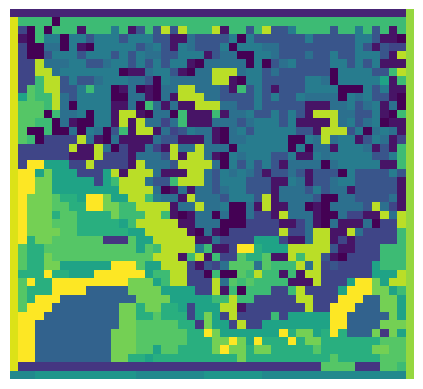

22 24


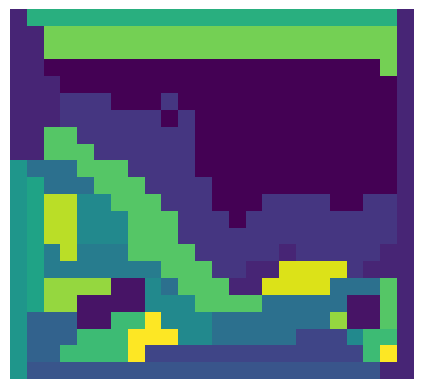

In [46]:
model.eval()
img_height,img_width = 699, 760
for idx, img in enumerate(observation[440:441]):
   img_t = get_normalized_tensor(img,model,device)
   image_sample = img_t.view(1,1,img_height,img_width)
   image_sample = image_sample.to(device=device, dtype=torch.float)
   with torch.no_grad():
      sample = model(image_sample)
      for i in range(len(sample['logvar'])):
         mu = sample['logvar'][i][0].cpu().numpy()
         # fig = plt.imshow(mu[0])
         # plt.axis('off')
         # plt.show()
         plotting(i, mu)
